### The goal of this notebook is to take the cleaned dataset from the data cleaning and label construction notebook, run some feature engineering and then do some exploratory analysis comparing the features to the credit label. We will primarily focus on the lifetime performance window.

### Feature Engineering

Our feature set has a mix of continuous features, binary categorical features, and multiclass features. We want to encode all these features in a way that puts them on level footing. As such, we will want to do two things: encode the multiclass labels via a one in k encoding and normalize the continuous features so they lie in between 0 and 1. Let's begin first by normalizing, as this is easy. The dataset we will use is the final dataframe constructed in the "Label Construction" notebook, which has the application data with one row per customer, along with labels for each customer. 

In [205]:
import sys
import itertools
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer

In [132]:
with open("application_data_with_harsh_delinquency_labels.csv", "r") as features:
    feature_df = pd.read_csv(features)
    

In [133]:
feature_df.drop(columns='Unnamed: 0', inplace=True)

In [134]:
print(feature_df.columns.values)

['ID' 'CODE_GENDER' 'FLAG_OWN_CAR' 'FLAG_OWN_REALTY' 'CNT_CHILDREN'
 'AMT_INCOME_TOTAL' 'NAME_INCOME_TYPE' 'NAME_EDUCATION_TYPE'
 'NAME_FAMILY_STATUS' 'NAME_HOUSING_TYPE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'FLAG_MOBIL' 'FLAG_WORK_PHONE' 'FLAG_PHONE' 'FLAG_EMAIL'
 'OCCUPATION_TYPE' 'CNT_FAM_MEMBERS' 'IDList' '6_Month' '12_Month'
 '24_Month' 'Lifetime']


In [135]:
rename_dict = {'CODE_GENDER': 'Gender', 'FLAG_OWN_CAR': 'Car', 'FLAG_OWN_REALTY':'Property', 'CNT_CHILDREN': 'Children',
                'AMT_INCOME_TOTAL': 'Income', 'NAME_INCOME_TYPE': 'Income_Type', 'NAME_EDUCATION_TYPE': 'Education',
                'NAME_FAMILY_STATUS': 'Marriage_Status', 'NAME_HOUSING_TYPE': 'Housing', 'DAYS_BIRTH': 'Age', 
                'DAYS_EMPLOYED': 'Employment_Length', 'FLAG_MOBIL': 'Mobile_Phone', 'FLAG_WORK_PHONE': 'Work_Phone',
                'FLAG_PHONE': 'Phone', 'FLAG_EMAIL': 'Email', 'OCCUPATION_TYPE': 'Occupation', 'CNT_FAM_MEMBERS': 'Family_Size'}

In [136]:
feat_normalized = feature_df.rename(columns=rename_dict)

In [137]:
Scaler = MinMaxScaler()
feat_normalized['Income']=Scaler.fit_transform(feat_normalized[['Income']])

In [138]:
Scaler = MinMaxScaler()
feat_normalized['Age']=1-Scaler.fit_transform(feat_normalized[['Age']])

In [146]:
Scaler = MinMaxScaler()
feat_normalized['Children']=Scaler.fit_transform(feat_normalized[['Children']])

In [151]:
Scaler = MinMaxScaler()
feat_normalized['Family_Size']=Scaler.fit_transform(feat_normalized[['Family_Size']])

To normalize the employment length, we need to a bit more careful, as unemployment has been input as simply a large positive number, and this will skew our ranges. We will simply normalize based on the employed customers and use that to transform our data.

In [153]:
Scaler = MinMaxScaler()
feat_employed = feat_normalized.loc[feat_normalized['Employment_Length']<=0]
scale = Scaler.fit(feat_employed[['Employment_Length']])
feat_normalized['Employment_Length'] = scale.transform(feat_normalized[['Employment_Length']])

In [154]:
feat_normalized.loc[feat_normalized['Employment_Length']>1]['Employment_Length']

3       24.270897
16      24.270897
24      24.270897
34      24.270897
40      24.270897
          ...    
9698    24.270897
9703    24.270897
9704    24.270897
9719    24.270897
9721    24.270897
Name: Employment_Length, Length: 1699, dtype: float64

The next step is to take the two class categories and enter them in binary form. 

In [155]:
feat_binary = feat_normalized.replace({'Y':1, 'N': 0, 'M':1, 'F':0})

In [156]:
feat_binary.iloc[100:200, :]

,ID,Gender,Car,Property,Children,Income,Income_Type,Education,Marriage_Status,Housing,...,Work_Phone,Phone,Email,Occupation,Family_Size,IDList,6_Month,12_Month,24_Month,Lifetime
100,5009423,0,0,0,0.000000,0.034884,Working,Secondary / secondary special,Civil marriage,House / apartment,...,0,0,0,Security staff,0.052632,[5009423],0.0,0.0,0.0,0.0
101,5009424,1,0,0,0.000000,0.052326,Working,Secondary / secondary special,Single / not married,Co-op apartment,...,1,0,0,Cooking staff,0.000000,"[5009424, 5009425]",0.0,1.0,1.0,1.0
102,5009426,1,0,0,0.000000,0.046512,Pensioner,Secondary / secondary special,Married,House / apartment,...,0,0,0,Null,0.052632,"[5009426, 5009427]",0.0,0.0,0.0,0.0
103,5009428,1,0,0,0.000000,0.110465,Working,Secondary / secondary special,Single / not married,With parents,...,1,0,0,Laborers,0.000000,"[5009428, 5009429]",0.0,0.0,0.0,0.0
104,5009431,1,1,0,0.000000,0.215116,State servant,Higher education,Married,Municipal apartment,...,1,1,0,Drivers,0.052632,[5009431],0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,5009952,1,1,1,0.000000,0.055233,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Null,0.052632,"[5009952, 5009954, 5009955]",1.0,1.0,1.0,1.0
196,5009957,0,1,1,0.052632,0.069767,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Null,0.105263,"[5009957, 5009958, 5009960, 5009961]",0.0,1.0,1.0,0.0
197,5009965,0,1,1,0.000000,0.098837,State servant,Secondary / secondary special,Married,House / apartment,...,0,0,0,Medicine staff,0.052632,"[5009965, 5009966, 5009967, 5009968, 5009969, ...",0.0,1.0,1.0,1.0
198,5009988,1,1,1,0.000000,0.302326,Pensioner,Higher education,Single / not married,House / apartment,...,0,0,0,Null,0.000000,"[5009988, 5009989, 5009990]",0.0,0.0,0.0,0.0


The last thing we need to do to construct our features + labels dataframe is to turn the multiclass categorical features into 1 in K binary features.

In [175]:
print(feat_binary.columns.values)

['ID' 'Gender' 'Car' 'Property' 'Children' 'Income' 'Income_Type'
 'Education' 'Marriage_Status' 'Housing' 'Age' 'Employment_Length'
 'Mobile_Phone' 'Work_Phone' 'Phone' 'Email' 'Occupation' 'Family_Size'
 'IDList' '6_Month' '12_Month' '24_Month' 'Lifetime']


In [177]:
categorical_columns = ['Income_Type', 'Education', 'Marriage_Status', 'Housing', 'Occupation']

In [190]:
feat_binarized = pd.get_dummies(feat_binary, columns=categorical_columns)

In [191]:
feat_binarized

,ID,Gender,Car,Property,Children,Income,Age,Employment_Length,Mobile_Phone,Work_Phone,...,Occupation_Low-skill Laborers,Occupation_Managers,Occupation_Medicine staff,Occupation_Null,Occupation_Private service staff,Occupation_Realty agents,Occupation_Sales staff,Occupation_Secretaries,Occupation_Security staff,Occupation_Waiters/barmen staff
0,5008804,1,1,1,0.0,0.258721,0.255676,0.711710,1,1,...,0,0,0,1,0,0,0,0,0,0
1,5008806,1,1,1,0.0,0.055233,0.791768,0.928835,1,0,...,0,0,0,0,0,0,0,0,1,0
2,5008808,0,0,1,0.0,0.156977,0.657929,0.806702,1,0,...,0,0,0,0,0,0,1,0,0,0
3,5008812,0,0,1,0.0,0.165698,0.847817,24.270897,1,0,...,0,0,0,1,0,0,0,0,0,0
4,5008815,1,1,1,0.0,0.156977,0.531223,0.952090,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9723,5148694,0,0,0,0.0,0.098837,0.742286,0.988468,1,0,...,0,0,0,0,0,0,0,0,0,0
9724,5149055,0,0,1,0.0,0.055233,0.472626,0.829447,1,1,...,0,0,0,1,0,0,0,0,0,0
9725,5149729,1,1,1,0.0,0.040698,0.657419,0.891437,1,0,...,0,0,0,1,0,0,0,0,0,0
9726,5149838,0,0,1,0.0,0.084302,0.277303,0.916667,1,0,...,0,0,1,0,0,0,0,0,0,0


In [184]:
features = feat_binarized.drop(columns=['ID', 'IDList', '6_Month', '12_Month', '24_Month', 'Lifetime'])

In [181]:
labels = feat_binarized['Lifetime']

### Weight of Evidence and Information Value

Weight of Evidence and Information Value are metrics to gauge the predictive power of the features in our dataset. These will serve us as useful feature selection methods for logistic regression, which is the model we will attempt first. To that end, let's describe how these metrics work. 

The weight of evidence of each class of a categorical feature is the natural log of the ratio of good customers (label 0) to bad customers (label 1) for customers whose feature values fall in that class. 

$$ WOE_{\text{class i}} = ln\left(\frac{\text{proportion of 0 labels in class i}}{\text{proportion of 1 labels in class i}}\right)$$

This value measures how well each class of the feature separates the good and bad customers. The information value uses the WOE and aggregates over each class in the category to measure how well the category as a whole separates good and bad customers. Given a category $x$, the information value of the category 

$$IV(x) = \displaystyle\sum_{\text{class i in x}} (\text{proprotion of good customers in i} - \text{proportion of bad customers in i})\cdot WOE_{i}.$$

In credit score modeling, the information value has historically corresponded with predictive power via the following table:

\begin{array}{cc}
\text{Information Value} & \text{Predictive Power}\\
0-0.02 & \text{No predictive power}\\
0.02-0.1 & \text{Weak predictive power}\\
0.1-0.3 & \text{Medium predictive power}\\
0.3-0.5 & \text{Strong predictive power}\\
0.5+ & \text{Suspicious feature}
\end{array}

For continuous data, we could compute information value by cutting the data into bins. Converting continuous to categorical data tends to lose a lot of information, so we don't want to convert it when putting it into our model, but it will give us a sense of how powerful these features are in predicting our label. We will do so later, for now we write some functions to compute the information value of our features. 

In [340]:
feat_binary[feat_binary['Car']==1]

,ID,Gender,Car,Property,Children,Income,Income_Type,Education,Marriage_Status,Housing,...,Work_Phone,Phone,Email,Occupation,Family_Size,IDList,6_Month,12_Month,24_Month,Lifetime
0,5008804,1,1,1,0.000000,0.258721,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,Null,0.052632,"[5008804, 5008805]",1.0,1.0,1.0,1.0
1,5008806,1,1,1,0.000000,0.055233,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Security staff,0.052632,[5008806],0.0,0.0,0.0,0.0
4,5008815,1,1,1,0.000000,0.156977,Working,Higher education,Married,House / apartment,...,1,1,1,Accountants,0.052632,"[5008815, 5112956]",0.0,0.0,0.0,0.0
5,5008819,1,1,1,0.000000,0.069767,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,0,0,Laborers,0.052632,"[5008819, 5008820, 5008821, 5008822, 5008823, ...",1.0,1.0,1.0,0.0
6,5008825,0,1,0,0.000000,0.066860,Working,Incomplete higher,Married,House / apartment,...,0,0,0,Accountants,0.052632,"[5008825, 5008826]",1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9708,5125763,1,1,0,0.052632,0.069767,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,0,Laborers,0.105263,[5125763],1.0,1.0,1.0,1.0
9709,5125816,0,1,0,0.000000,0.273256,Pensioner,Higher education,Married,House / apartment,...,1,1,0,Managers,0.052632,[5125816],0.0,0.0,1.0,1.0
9718,5143578,1,1,0,0.000000,0.084302,Working,Incomplete higher,Single / not married,With parents,...,1,0,0,Drivers,0.052632,[5143578],0.0,1.0,1.0,1.0
9720,5145760,0,1,0,0.000000,0.069767,Working,Higher education,Married,House / apartment,...,0,0,1,Null,0.052632,[5145760],1.0,1.0,1.0,1.0


In [366]:
def LabelDist(feature, feature_class, label='Lifetime', df=feat_binary):
    '''Inputs: A dataframe, a column name representing categorical feature, the name of the label column. 
       Returns a list with the percentage of entries in the class with label 0 and the percentage with class 1.'''
    
    df_class = df[df[feature]==feature_class]
    data_size = df[label].size
    bad_total = df[label].sum()
    good_total = data_size - bad_total
    class_size = df_class[label].size
    bad_class = df_class[label].sum()
    good_class = class_size - bad_class
    
    good_percentage = (good_class/good_total)
    bad_percentage = (bad_class/bad_total)
    
    return [good_percentage, bad_percentage]

def WOE(feature, feature_class, label='Lifetime', df=feat_binary):
    '''Inputs: A dataframe, a column name representing categorical feature, the name of the label column. 
       Returns the weight of evidence of the category. If either the positive or negative labels 
        are absent from the category, returns NaN.'''
    
    if LabelDist(feature, feature_class, label, df=df)[0] ==0 or LabelDist(feature, feature_class, label, df=df)[1]==0:
        return np.nan
    
    else:
        a = LabelDist(feature, feature_class, label, df=df)[0]
        b = LabelDist(feature, feature_class, label, df=df)[1]
        return math.log(a/b)

In [362]:
def InfoValue(feature, label='Lifetime', df=feat_binary):
    '''Inputs: A dataframe, a column name representing categorical feature, the name of the label column.
       Returns the information value of that column.'''
    IV = 0
    for category in set(df[feature].values):
        x = (LabelDist(feature, category, label, df=df)[0]-LabelDist(feature, category, label, df=df)[1])*WOE(feature, category, label, df=df)
        print(x)
        IV+= x
    return IV

Let us now compute the information values for our 2-class and multiclass categorical features. 

In [226]:
print(feat_binary.columns.values)

['ID' 'Gender' 'Car' 'Property' 'Children' 'Income' 'Income_Type'
 'Education' 'Marriage_Status' 'Housing' 'Age' 'Employment_Length'
 'Mobile_Phone' 'Work_Phone' 'Phone' 'Email' 'Occupation' 'Family_Size'
 'IDList' '6_Month' '12_Month' '24_Month' 'Lifetime']


In [293]:
binary_features = ['Gender', 'Car', 'Property', 'Mobile_Phone', 'Work_Phone', 'Phone', 'Email']
multiclass_features = ['Income_Type', 'Education', 'Marriage_Status', 'Occupation', 'Housing']

categorical_features = binary_features + multiclass_features

In [294]:
feat_categorical = feat_binary.loc[:, categorical_features]

In [295]:
IV_List = []
for entry in feat_categorical.columns.values:
    IV_List.append([entry, InfoValue(entry)])
    

In [296]:
IV_dataframe = pd.DataFrame(IV_List, columns=['Feature', 'Information_Value'])
print(IV_dataframe)

            Feature  Information_Value
0            Gender           0.000292
1               Car           0.000075
2          Property           0.006584
3      Mobile_Phone           0.000000
4        Work_Phone           0.000023
5             Phone           0.000077
6             Email           0.003243
7       Income_Type           0.004413
8         Education           0.003251
9   Marriage_Status           0.004449
10       Occupation           0.013850
11          Housing           0.004106


These information values are very low, which indicates that, unless our continuous features separate the data better, logistic regression is unlikely to give us a particularly strong model. We will probably want to use other classification methods and see if they give better results. To end this exploratory analysis, let us convert our continuous features into categorical features via cutting them into bins and then compute the information value of these features.

In [287]:
continuous_features = ['Children', 'Income', 'Age', 'Employment_Length', 'Family_Size']

In [288]:
def ContinuousToCategory(feature, df=feat_binary, num_bins=10):
    '''Inputs: A dataframe, a column name representing a continuous feature and the number of bins to cut the feature into.
       Returns: A pandas series representing the categorical version of the feature.'''
    return pd.qcut(df[feature], q=num_bins, duplicates='drop')

In [289]:
feat_cont_to_cat = feat_binary.copy()
for entry in continuous_features:
    feat_cont_to_cat['Cat_'+entry] = ContinuousToCategory(entry)

In [269]:
feat_cont_to_cat

,ID,Gender,Car,Property,Children,Income,Income_Type,Education,Marriage_Status,Housing,...,Family_Size,IDList,6_Month,12_Month,24_Month,Lifetime,Cat_Income,Cat_Age,Cat_Employment_Length,Cat_Family_Size
0,5008804,1,1,1,0.0,0.258721,Working,Higher education,Civil marriage,Rented apartment,...,0.052632,"[5008804, 5008805]",1.0,1.0,1.0,1.0,"(0.172, 1.0]","(0.245, 0.317]","(0.673, 0.781]","(-0.001, 0.0526]"
1,5008806,1,1,1,0.0,0.055233,Working,Secondary / secondary special,Married,House / apartment,...,0.052632,[5008806],0.0,0.0,0.0,0.0,"(0.0407, 0.0552]","(0.726, 0.821]","(0.914, 0.941]","(-0.001, 0.0526]"
2,5008808,0,0,1,0.0,0.156977,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0.000000,"[5008808, 5008809, 5008810, 5008811]",1.0,1.0,1.0,0.0,"(0.128, 0.172]","(0.636, 0.726]","(0.781, 0.839]","(-0.001, 0.0526]"
3,5008812,0,0,1,0.0,0.165698,Pensioner,Higher education,Separated,House / apartment,...,0.000000,"[5008812, 5008813, 5008814]",0.0,0.0,1.0,0.0,"(0.128, 0.172]","(0.821, 1.0]","(0.99, 24.271]","(-0.001, 0.0526]"
4,5008815,1,1,1,0.0,0.156977,Working,Higher education,Married,House / apartment,...,0.052632,"[5008815, 5112956]",0.0,0.0,0.0,0.0,"(0.128, 0.172]","(0.46, 0.546]","(0.941, 0.968]","(-0.001, 0.0526]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9723,5148694,0,0,0,0.0,0.098837,Pensioner,Secondary / secondary special,Civil marriage,Municipal apartment,...,0.052632,[5148694],1.0,1.0,1.0,1.0,"(0.0843, 0.0988]","(0.726, 0.821]","(0.968, 0.99]","(-0.001, 0.0526]"
9724,5149055,0,0,1,0.0,0.055233,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0.052632,"[5149055, 5149056]",1.0,1.0,1.0,1.0,"(0.0407, 0.0552]","(0.46, 0.546]","(0.781, 0.839]","(-0.001, 0.0526]"
9725,5149729,1,1,1,0.0,0.040698,Working,Secondary / secondary special,Married,House / apartment,...,0.052632,[5149729],1.0,1.0,1.0,1.0,"(-0.001, 0.0407]","(0.636, 0.726]","(0.882, 0.914]","(-0.001, 0.0526]"
9726,5149838,0,0,1,0.0,0.084302,Pensioner,Higher education,Married,House / apartment,...,0.052632,[5149838],1.0,1.0,1.0,1.0,"(0.0698, 0.0843]","(0.245, 0.317]","(0.914, 0.941]","(-0.001, 0.0526]"


In [290]:
feat_cont_to_cat['Cat_Income']

0           (0.172, 1.0]
1       (0.0407, 0.0552]
2         (0.128, 0.172]
3         (0.128, 0.172]
4         (0.128, 0.172]
              ...       
9723    (0.0843, 0.0988]
9724    (0.0407, 0.0552]
9725    (-0.001, 0.0407]
9726    (0.0698, 0.0843]
9727    (0.0407, 0.0552]
Name: Cat_Income, Length: 9728, dtype: category
Categories (10, interval[float64, right]): [(-0.001, 0.0407] < (0.0407, 0.0552] < (0.0552, 0.0669] < (0.0669, 0.0698] ... (0.0988, 0.113] < (0.113, 0.128] < (0.128, 0.172] < (0.172, 1.0]]

In [291]:
Cont_IV_List = []
for entry in continuous_features:
    Cont_IV_List.append([entry, InfoValue(feature='Cat_'+entry, df=feat_cont_to_cat)])

In [292]:
Cont_IV_dataframe = pd.DataFrame(Cont_IV_List, columns=['Category', 'Information_Value'])

print(Cont_IV_dataframe)

            Category  Information_Value
0           Children           0.000488
1             Income           0.010727
2                Age           0.026742
3  Employment_Length           0.011423
4        Family_Size           0.000962


When we conduct our logistic regression, we will remove some of the features that have very low information value. We will build our models in a different notebook. Let us save the dataframes we will use in that notebook. 

In [285]:
feat_binary.to_csv(r'feature_dataframe_without_one_in_K.csv')

In [286]:
feat_binarized.to_csv(r'feature_dataframe_with_one_in_K.csv')

As a way to judge how well our features predict our labels without the assumption of a logistic distribution, let us also compute the correlation coefficients between the features and the variables.

In [385]:
def corr(series, df=feat_binary, label='Lifetime'):
    '''Takes a column of a dataframe df with a 2 class label column and returns 
        the correlation coefficient of the series with the label.'''
    return pd.Series(series.corr(df[label]))




In [388]:
feat_without_id = feat_binarized.drop(columns=['ID', 'IDList'])

feat_without_id

,Gender,Car,Property,Children,Income,Age,Employment_Length,Mobile_Phone,Work_Phone,Phone,...,Occupation_Low-skill Laborers,Occupation_Managers,Occupation_Medicine staff,Occupation_Null,Occupation_Private service staff,Occupation_Realty agents,Occupation_Sales staff,Occupation_Secretaries,Occupation_Security staff,Occupation_Waiters/barmen staff
0,1,1,1,0.0,0.258721,0.255676,0.711710,1,1,0,...,0,0,0,1,0,0,0,0,0,0
1,1,1,1,0.0,0.055233,0.791768,0.928835,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0.0,0.156977,0.657929,0.806702,1,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0.0,0.165698,0.847817,24.270897,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,1,1,0.0,0.156977,0.531223,0.952090,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9723,0,0,0,0.0,0.098837,0.742286,0.988468,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9724,0,0,1,0.0,0.055233,0.472626,0.829447,1,1,1,...,0,0,0,1,0,0,0,0,0,0
9725,1,1,1,0.0,0.040698,0.657419,0.891437,1,0,0,...,0,0,0,1,0,0,0,0,0,0
9726,0,0,1,0.0,0.084302,0.277303,0.916667,1,0,1,...,0,0,1,0,0,0,0,0,0,0


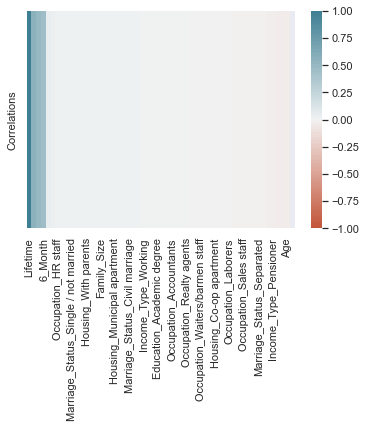

In [389]:
correlations = feat_without_id.apply(corr).rename(index={0: "Correlations"})

sorted_correlations = correlations.sort_values(by="Correlations", axis=1, ascending=False)

%matplotlib inline
sns.set_theme()
ax = sns.heatmap(sorted_correlations, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200))

In [390]:
print(sorted_correlations)

              Lifetime  12_Month  24_Month   6_Month    Income     Email  \
Correlations       1.0  0.558725  0.503709  0.466986  0.039885  0.025051   

              Occupation_HR staff  Occupation_Core staff  \
Correlations             0.022895                0.02143   

              Occupation_Security staff  Marriage_Status_Single / not married  \
Correlations                   0.020658                              0.019519   

              ...  Occupation_Private service staff  \
Correlations  ...                         -0.015918   

              Education_Secondary / secondary special  \
Correlations                                -0.017752   

              Marriage_Status_Separated  Occupation_Null  \
Correlations                  -0.018051        -0.020439   

              Housing_House / apartment  Income_Type_Pensioner  \
Correlations                   -0.02518              -0.027401   

              Employment_Length  Property       Age  Mobile_Phone  
Correlations   

This table is also very discouraging. None of our features are particularly strongly correlated with our labels. 
Let us see if we get better correlations with labels corresponding to the other time periods.

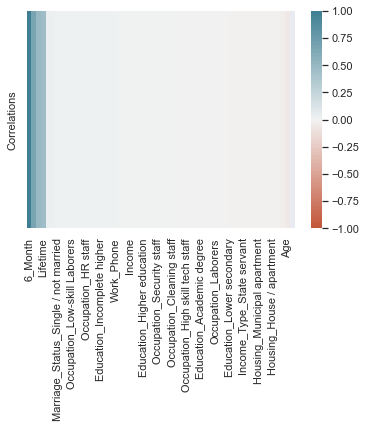

In [391]:
correlations_6_month = feat_without_id.apply(lambda x: corr(x, label='6_Month')).rename(index={0: "Correlations"})

sorted_correlations_6_month = correlations_6_month.sort_values(by="Correlations", axis=1, ascending=False)

%matplotlib inline
sns.set_theme()
ax = sns.heatmap(sorted_correlations_6_month, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200))

In [392]:
print(sorted_correlations_6_month)

              6_Month  12_Month  24_Month  Lifetime  Children  \
Correlations      1.0  0.663934  0.499699  0.466986  0.028991   

              Housing_With parents  Marriage_Status_Single / not married  \
Correlations              0.023639                              0.022901   

              Occupation_Private service staff  Housing_Rented apartment  \
Correlations                          0.020618                  0.020198   

              Occupation_Low-skill Laborers  ...  Occupation_Managers  \
Correlations                       0.017368  ...            -0.010781   

                   Car  Housing_Municipal apartment  Employment_Length  \
Correlations -0.010994                    -0.012474          -0.012753   

              Occupation_Drivers  Housing_House / apartment  Property  \
Correlations           -0.013082                  -0.021008  -0.02224   

              Marriage_Status_Married       Age  Mobile_Phone  
Correlations                -0.024603 -0.051719         

              12_Month  24_Month   6_Month  Lifetime  Children  \
Correlations       1.0  0.752634  0.663934  0.558725  0.033152   

              Housing_Rented apartment  Family_Size  \
Correlations                  0.029962     0.027034   

              Education_Incomplete higher  \
Correlations                     0.023795   

              Marriage_Status_Single / not married  Income_Type_Working  ...  \
Correlations                              0.022906             0.022171  ...   

              Occupation_Null  Education_Secondary / secondary special  \
Correlations        -0.014427                                -0.016584   

              Education_Lower secondary  Occupation_Laborers  \
Correlations                  -0.017522            -0.018813   

              Income_Type_Pensioner  Housing_House / apartment  \
Correlations              -0.020116                   -0.02213   

              Marriage_Status_Separated  Employment_Length      Age  \
Correlations          

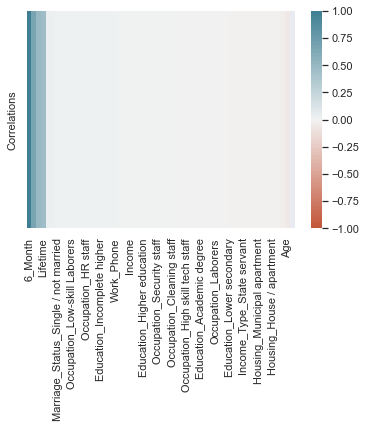

In [393]:
correlations_12_month = feat_without_id.apply(lambda x: corr(x, label='12_Month')).rename(index={0: "Correlations"})

sorted_correlations_12_month = correlations_12_month.sort_values(by="Correlations", axis=1, ascending=False)

%matplotlib inline
sns.set_theme()
ax = sns.heatmap(sorted_correlations_6_month, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200))

print(sorted_correlations_12_month)

              24_Month  12_Month  Lifetime   6_Month  Children  Family_Size  \
Correlations       1.0  0.752634  0.503709  0.499699  0.034679     0.032244   

              Income_Type_Working  Education_Incomplete higher  \
Correlations             0.030429                     0.029668   

              Housing_Rented apartment    Income  ...  Occupation_Laborers  \
Correlations                  0.028981  0.026427  ...             -0.01547   

              Education_Lower secondary  Occupation_IT staff  Occupation_Null  \
Correlations                  -0.017183            -0.017395        -0.017884   

              Education_Secondary / secondary special  \
Correlations                                -0.018644   

              Housing_House / apartment  Income_Type_Pensioner  \
Correlations                  -0.022307              -0.034215   

              Employment_Length       Age  Mobile_Phone  
Correlations          -0.038143 -0.067974           NaN  

[1 rows x 56 columns]


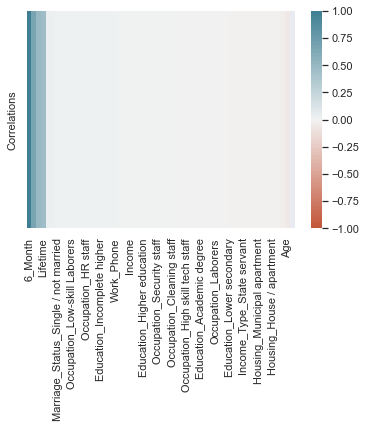

In [394]:
correlations_24_month = feat_without_id.apply(lambda x: corr(x, label='24_Month')).rename(index={0: "Correlations"})

sorted_correlations_24_month = correlations_24_month.sort_values(by="Correlations", axis=1, ascending=False)

%matplotlib inline
sns.set_theme()
ax = sns.heatmap(sorted_correlations_6_month, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200))

print(sorted_correlations_24_month)

We get some small improvements in correlation strength for the 24 month label but these are still minor. Our hope is that a clever model will be able to pick up on small relationships to give us a reasonable predictor.